In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


from scipy import stats
from scipy.stats import normaltest
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

In [99]:
store = pd.read_csv('/content/drive/MyDrive/周二/store.csv')
train = pd.read_csv('/content/drive/MyDrive/周二/train.csv',parse_dates = True, low_memory = False,index_col='Date')
test = pd.read_csv('/content/drive/MyDrive/周二/test.csv',parse_dates = True, low_memory = False,index_col='Date')

In [100]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [101]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


## Convert date format

#### split the date

In [102]:
train['year'] = train.index.year
train['month'] = train.index.month
train['day'] = train.index.day
train['weekofyear'] = train.index.isocalendar().week

In [103]:
test['year'] = test.index.year
test['month'] = test.index.month
test['day'] = test.index.day
test['weekofyear'] = test.index.isocalendar().week

In [104]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
 8   year           1017209 non-null  int32 
 9   month          1017209 non-null  int32 
 10  day            1017209 non-null  int32 
 11  weekofyear     1017209 non-null  UInt32
dtypes: UInt32(1), int32(3), int64(7), object(1)
memory usage: 86.3+ MB


In [105]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear
Date,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31


## Add new parameters

#### Create a new column: per capita consumption

In [106]:
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

## Handle null value

In [107]:
train.isna().sum()

Store                   0
DayOfWeek               0
Sales                   0
Customers               0
Open                    0
Promo                   0
StateHoliday            0
SchoolHoliday           0
year                    0
month                   0
day                     0
weekofyear              0
SalePerCustomer    172869
dtype: int64

In [108]:
test.isna().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
year              0
month             0
day               0
weekofyear        0
dtype: int64

In [109]:
train.fillna(0,inplace  = True)

In [110]:
test = test.dropna()

## ECDF diagrams  
ECDF diagrams usually appear as a stepped polyline. Each step corresponds to an observation in the data set (or all observations in an interval). The line segments rise step by step from left to right, and the height indicates what proportion of the data points fall at this value or smaller at the current x value.

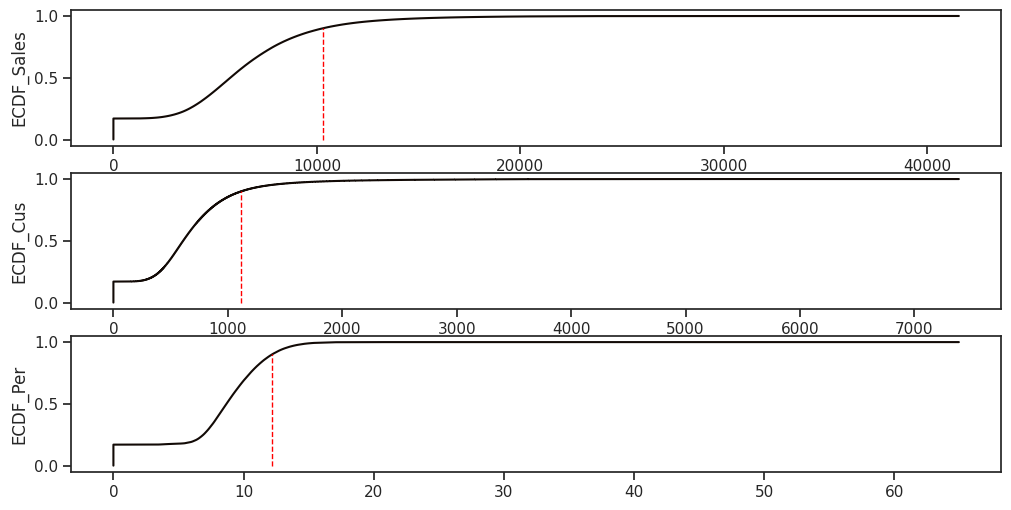

In [111]:
sns.set(style = "ticks")# to format into seaborn
c = '#120a06' # basic color for plots
plt.figure(figsize = (12, 6))
probability_threshold = 0.9

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);

vline_x_position = cdf.x[cdf.y >= probability_threshold][0]
plt.vlines(vline_x_position, ymin=0, ymax=probability_threshold,
           colors='red', linestyles='dashed', linewidth=1,
           label=f"Cumulative Probability {probability_threshold*100}%");
plt.xlabel('Sales');
plt.ylabel('ECDF_Sales');

# plot second ECDF
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);

vline_x_position = cdf.x[cdf.y >= probability_threshold][0]
plt.vlines(vline_x_position, ymin=0, ymax=probability_threshold,
           colors='red', linestyles='dashed', linewidth=1,
           label=f"Cumulative Probability {probability_threshold*100}%");
plt.ylabel('ECDF_Cus');
plt.xlabel('Customers');

# plot third ECDF
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);

vline_x_position = cdf.x[cdf.y >= probability_threshold][0]
plt.vlines(vline_x_position, ymin=0, ymax=probability_threshold,
           colors='red', linestyles='dashed', linewidth=1,
           label=f"Cumulative Probability {probability_threshold*100}%");
plt.ylabel('ECDF_Per');

## Closed stores and zero sales stores

#### Some stores are closed and not open for business，16.98% of the stores closed and had no sales, and we're going to get rid of those values.

In [112]:
train[(train['Sales']==0) & (train['Open']==0)]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,0.0
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,0.0
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,0.0
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,0.0
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1,2013,1,1,1,0.0
2013-01-01,1112,2,0,0,0,0,a,1,2013,1,1,1,0.0
2013-01-01,1113,2,0,0,0,0,a,1,2013,1,1,1,0.0


In [113]:
train[(train['Sales']==0) & (train['Open']==0)].shape[0]/train.shape[0]*100

16.989330609540417

There were 53 days when the store was open but there was no turnover, which we can remove as an anomaly

In [114]:
train[(train['Sales']==0) & (train['Open']!=0)].shape

(54, 13)

In [115]:
train = train[(train['Sales']!=0) & (train['Open']!=0)]
train.shape

(844338, 13)

In [116]:
{"Mean":np.mean(train.Sales),"Median":np.median(train.Sales)}

{'Mean': 6955.959133664481, 'Median': 6369.0}

In [117]:
{"Mean":np.mean(train.Customers),"Median":np.median(train.Customers)}

{'Mean': 762.777166253325, 'Median': 676.0}

In [118]:
train['Customers'].describe()

count    844338.000000
mean        762.777166
std         401.194153
min           8.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64

## Store file

In [119]:
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

#### Fill null

In [120]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(),inplace = True)

In [121]:
_  = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2!=0].shape

(0, 10)

In [122]:
store.fillna(0,inplace = True)

## Merge train set with an additional store information

In [123]:
train_store = pd.merge(train,store,how='inner',on ='Store')
train_store.shape

(844338, 22)

In [124]:
test_store = pd.merge(test,store,how = 'inner',on = 'Store')
test_store.shape

(41077, 20)

In [125]:
train_store.head(5)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## Storetype-based analysis

In [126]:
train_store.groupby('StoreType')['Sales'].describe().sort_values('mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


Store B has the higest average of Sales among all others, however we have much data for it.So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

In [127]:
train_store.groupby('StoreType')[['Customers','Sales']].sum().sort_values('Customers',ascending=False)

,Customers,Sales
StoreType,,
a,363541431,3165334859
d,156904995,1765392943
c,92129705,783221426
b,31465616,159231395


The number of customers and sales of each type are the same.

In [128]:
pd.DataFrame(train_store[['StoreType','Promo']].value_counts(normalize=True))

proportion
StoreType Promo            
a         0        0.299089
          1        0.242213
d         0        0.169451
          1        0.137023
c         0        0.073709
          1        0.060086
b         0        0.011396
          1        0.007033

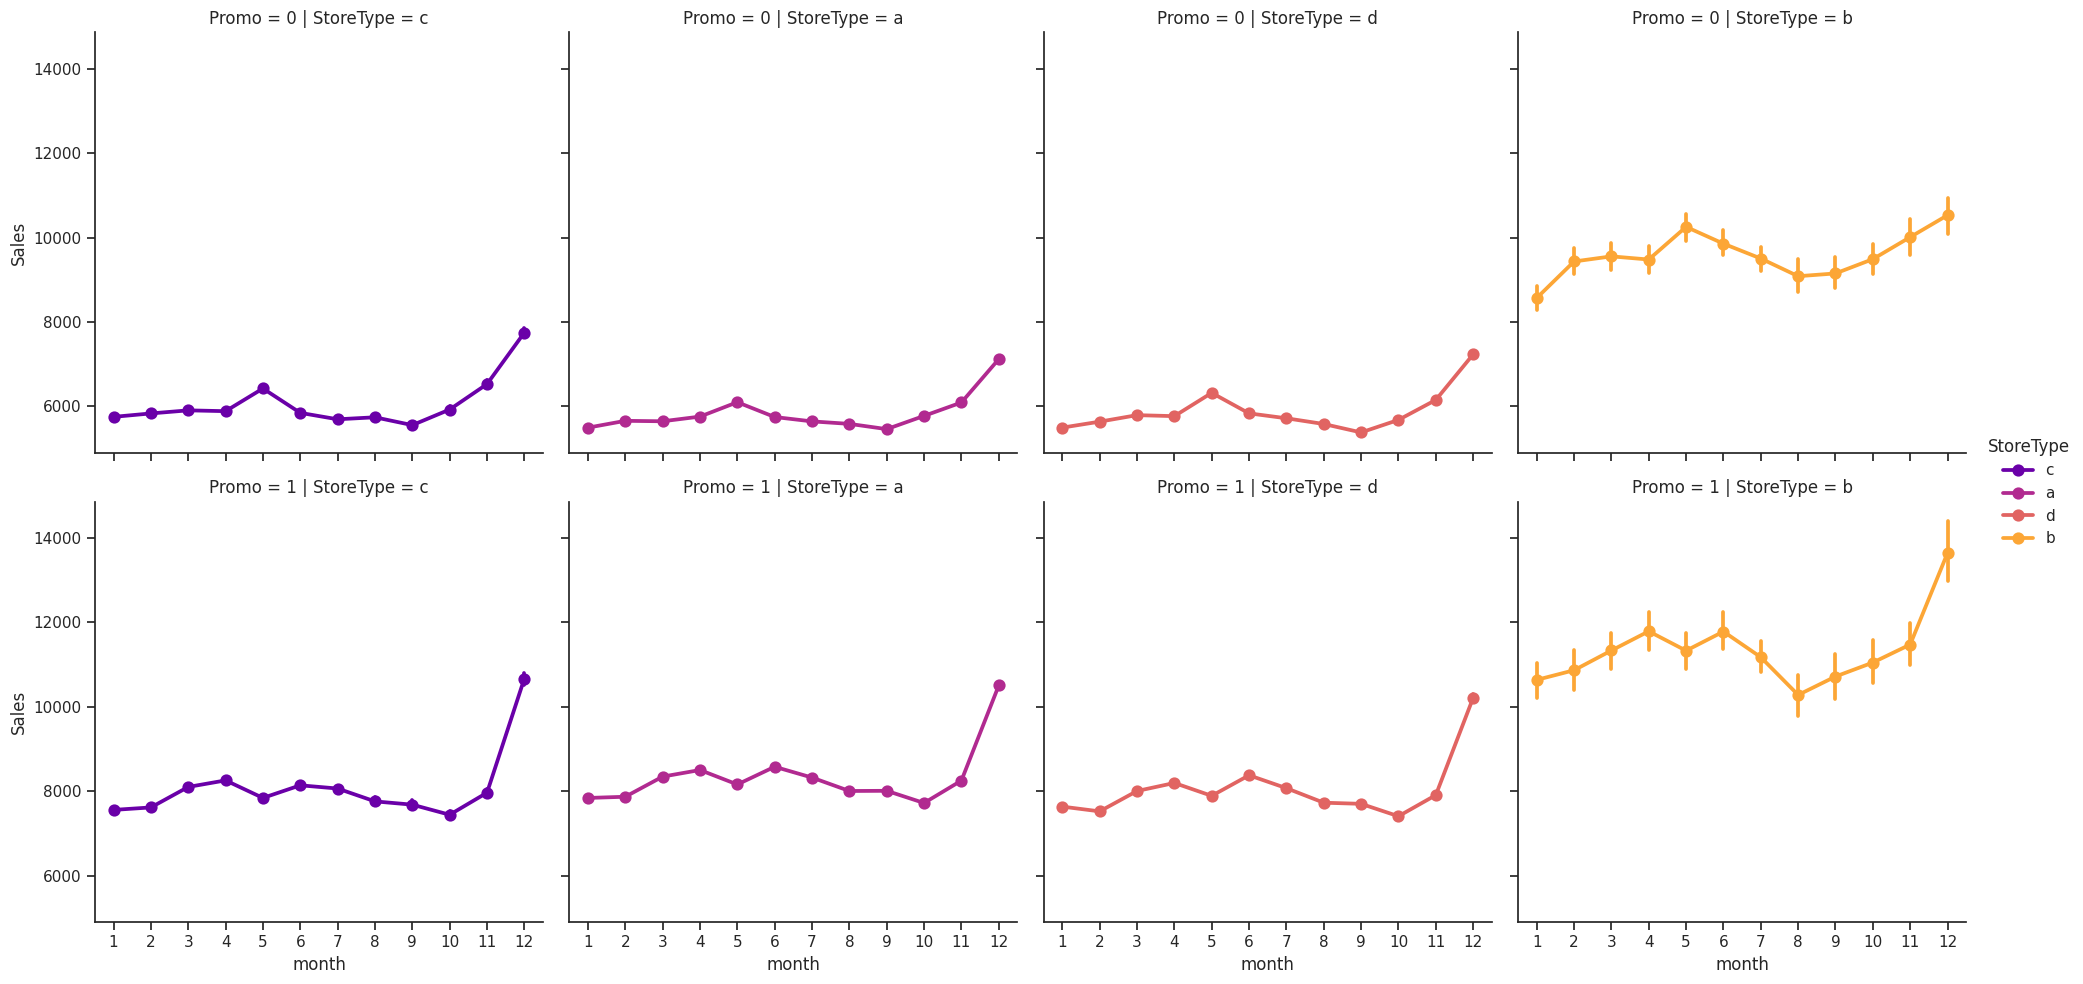

In [129]:
# sales trends
sns.catplot(data = train_store, x = 'month', y = "Sales",
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c,
               kind = 'point')

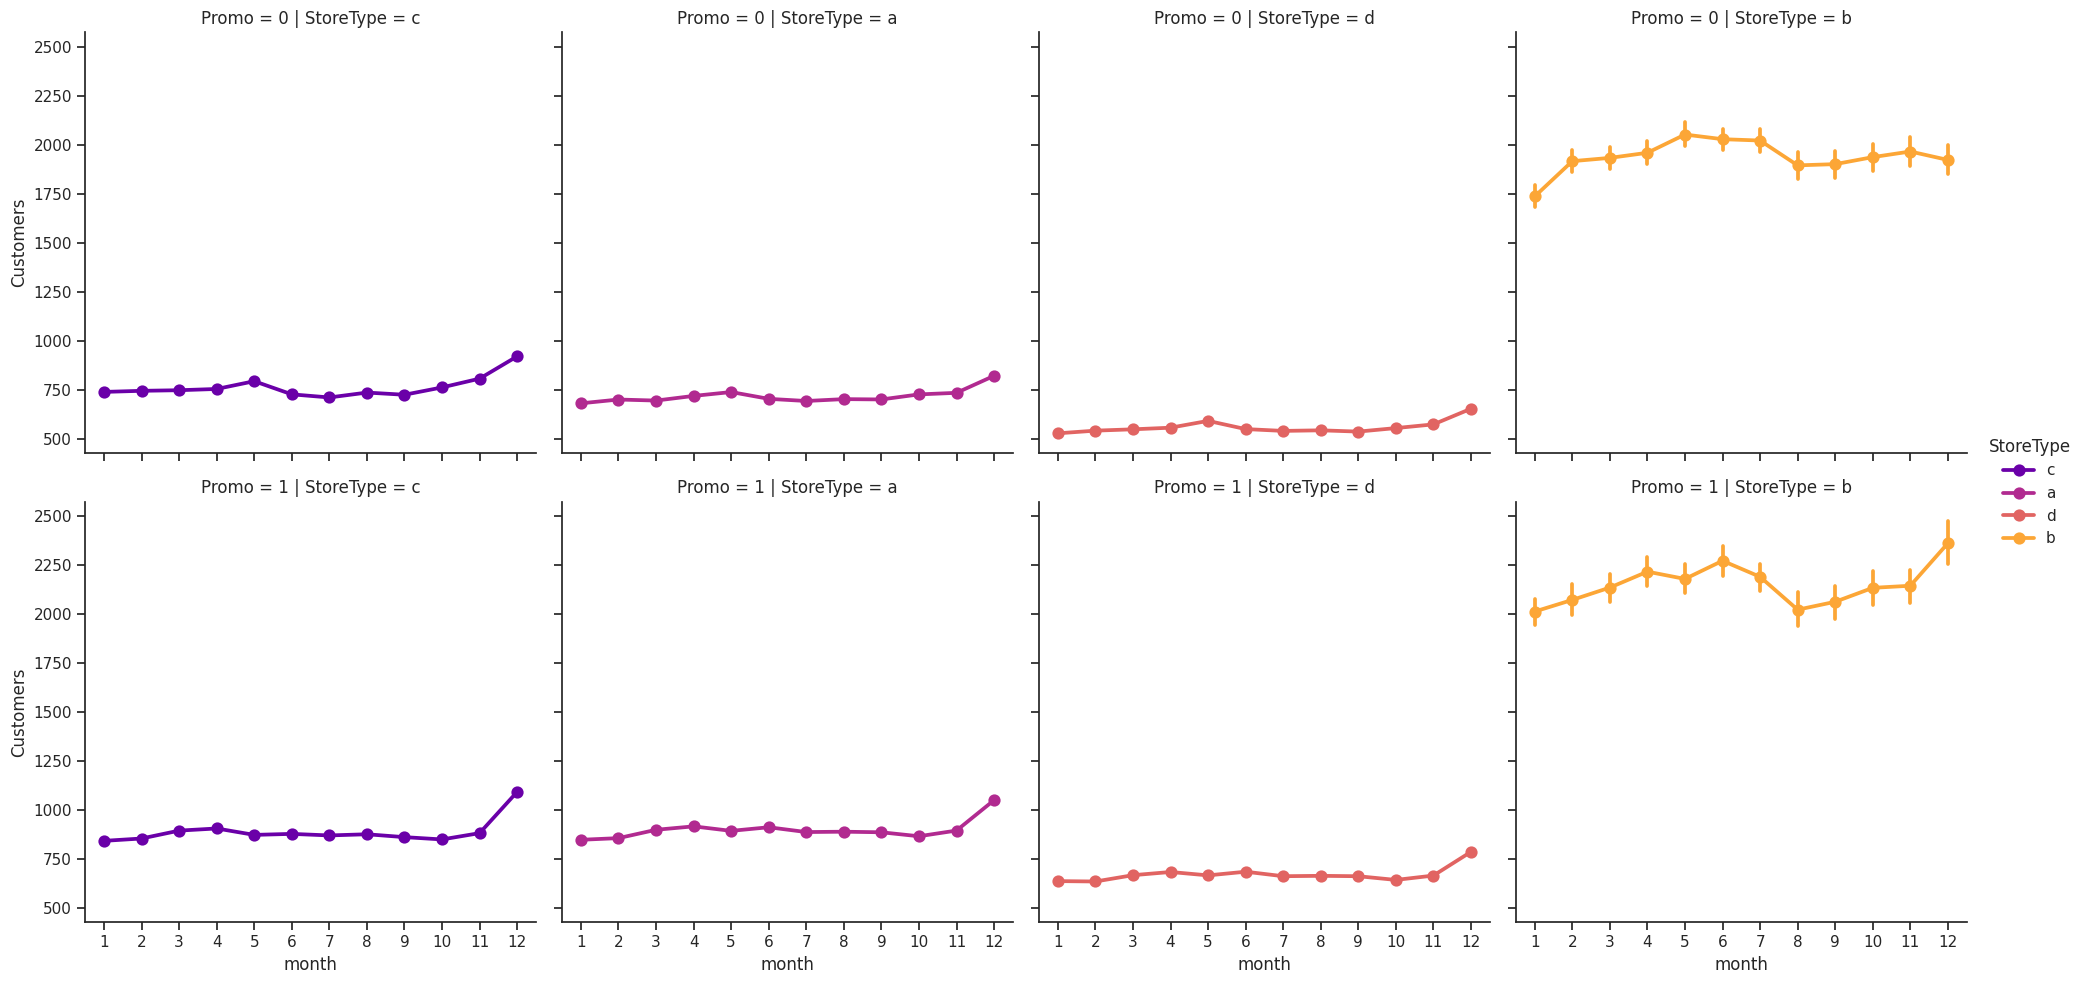

In [130]:
sns.catplot(data = train_store, x = 'month', y = "Customers",
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo',
               color = c,
               kind = 'point')

All store types follow the same trend but at different scales depending on the presence of the (first) promotion Promo and StoreType itself (case for B).  
Type B is small in number but has a high average of customers and sales.

Already at this point, we can see that Sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section.¶

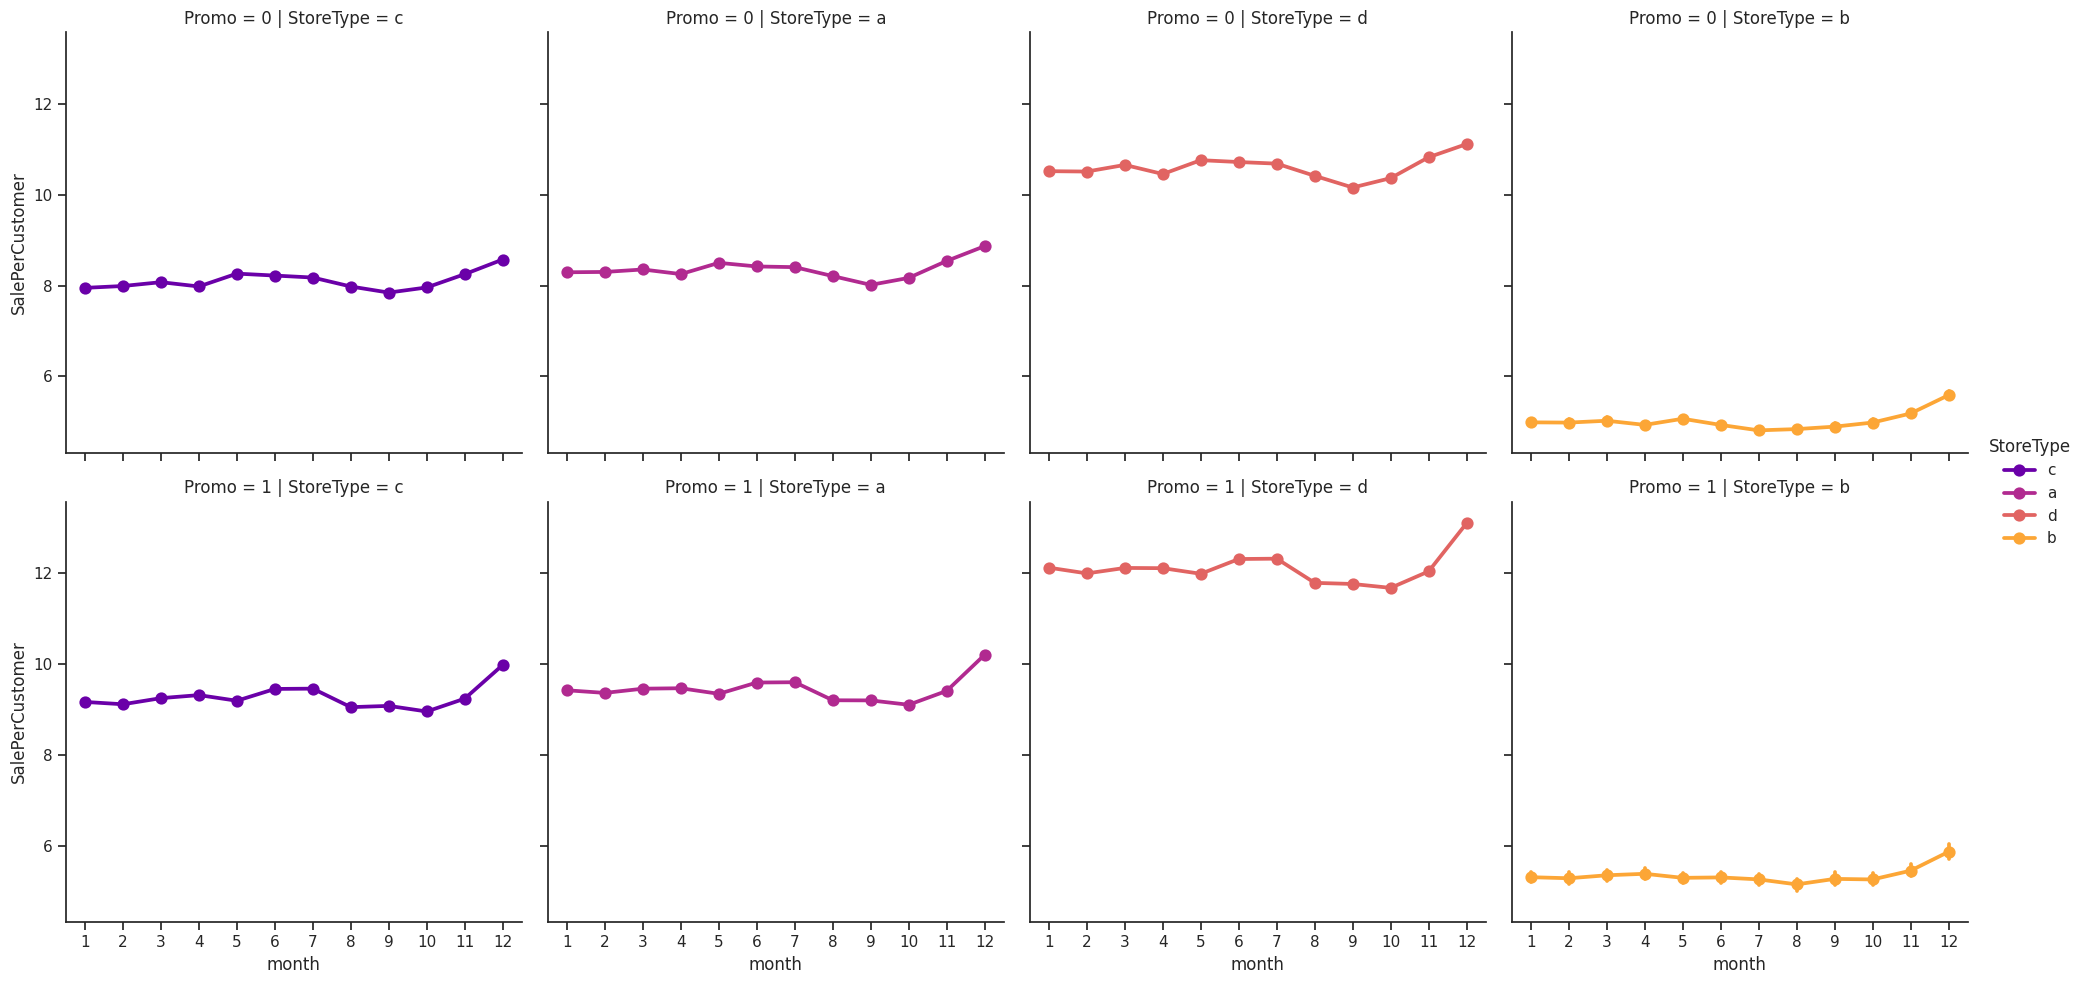

In [131]:
sns.catplot(data = train_store, x = 'month', y = "SalePerCustomer",
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c,
               kind = 'point')

Eventhough the plots above showed StoreType B as the most selling and performant one, in reality it is not true. The highest SalePerCustomer amount is observed at the StoreType D.  
Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this StoreType generated the least amount of sales and customers over the period.

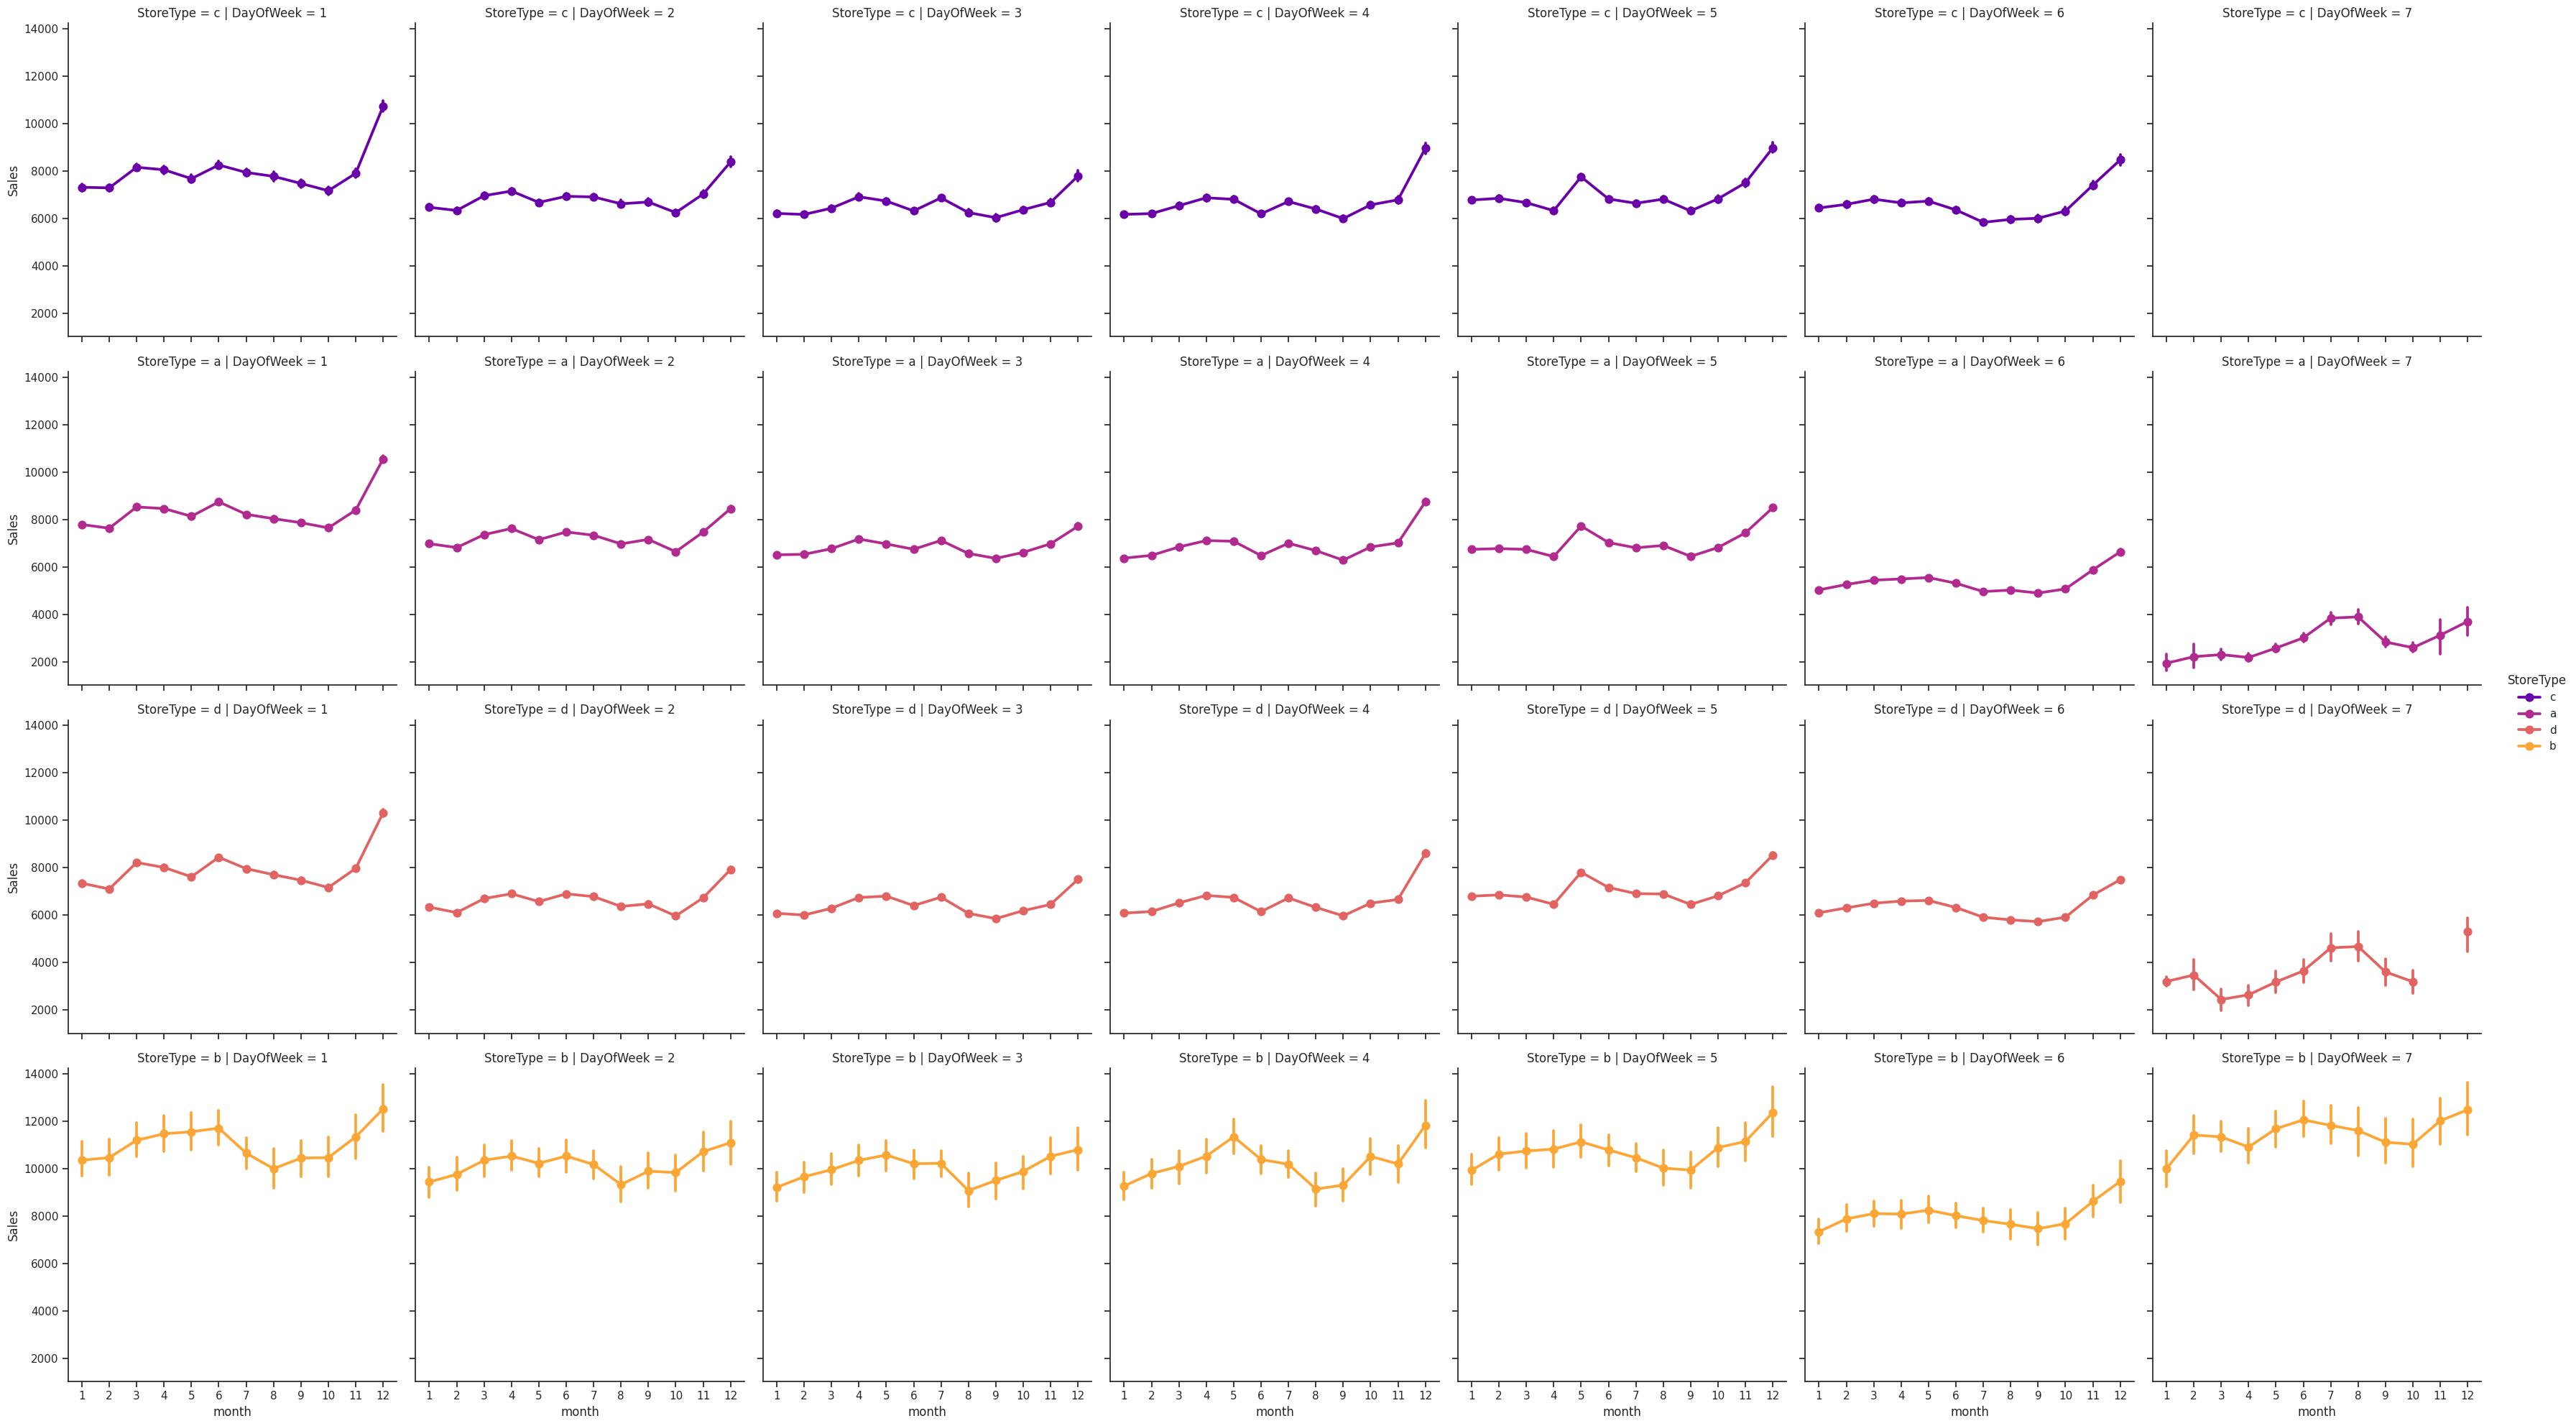

In [132]:
sns.catplot(data = train_store, x = 'month', y = "Sales",
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c,
               kind='point')

Type c stores are closed every Sunday, and Type d locations are only closed on Sundays from October to December

These are available at locations open on Sundays:

In [133]:
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

#### Calculate the promotion time since the store opened and the appearance time of competitors

In [134]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.year - train_store.CompetitionOpenSinceYear) + \
        (train_store.month - train_store.CompetitionOpenSinceMonth)

# Promo open time
train_store['PromoOpen'] = 12 * (train_store.year - train_store.Promo2SinceYear) + \
        (train_store.weekofyear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

#Temporarily block records that have no competitors
tain_store_Comana = train_store[train_store['CompetitionOpenSinceYear']!=0]
tain_store_Comana = tain_store_Comana[tain_store_Comana['Promo2SinceYear']!=0]

# average PromoOpen time and CompetitionOpen time per store type
competitive_inf = tain_store_Comana.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

In [135]:
# competition open time (in months)
test_store['CompetitionOpen'] = 12 * (test_store.year - test_store.CompetitionOpenSinceYear) + \
        (test_store.month - test_store.CompetitionOpenSinceMonth)

# Promo open time
test_store['PromoOpen'] = 12 * (test_store.year - test_store.Promo2SinceYear) + \
        (test_store.weekofyear - test_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
test_store.fillna(0, inplace = True)

In [136]:
competitive_inf['inf_diff'] = competitive_inf['PromoOpen'] - competitive_inf['CompetitionOpen']
competitive_inf.sort_values('inf_diff')

,Sales,Customers,PromoOpen,CompetitionOpen,inf_diff
StoreType,,,,,
c,6298.588125,724.148030,25.242617,76.374583,-51.131966
a,6544.752591,721.197911,23.32097,65.272556,-41.951586
d,6627.022058,562.835642,24.478036,63.138169,-38.660133


In [137]:
tain_store_Comana.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').count()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,147056,147056,147056,147056
c,35047,35047,35047,35047
d,85685,85685,85685,85685


Type B has no rivals or has not calculated the opening time of its rivals. The remaining three types basically aim to appear earlier than their competitors.

In [138]:
competitive_inf2 = tain_store_Comana[tain_store_Comana['PromoOpen']>tain_store_Comana['CompetitionOpen']].loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()
competitive_inf2['inf_diff'] = competitive_inf2['PromoOpen'] - competitive_inf2['CompetitionOpen']
competitive_inf2.sort_values('inf_diff')

,Sales,Customers,PromoOpen,CompetitionOpen,inf_diff
StoreType,,,,,
a,6548.734410,738.742965,32.884892,9.859251,23.025641
d,7024.112871,592.360610,33.760437,7.705025,26.055412
c,6203.375025,685.199133,39.070908,12.113650,26.957258


In [139]:
tain_store_Comana[tain_store_Comana['PromoOpen']>tain_store_Comana['CompetitionOpen']].loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').count()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,41613,41613,41613,41613
c,5077,5077,5077,5077
d,22229,22229,22229,22229


#### If we simply look at the stores that offer discounts only after competitors appear, store A has the largest number and the fastest response.

## Heatmap

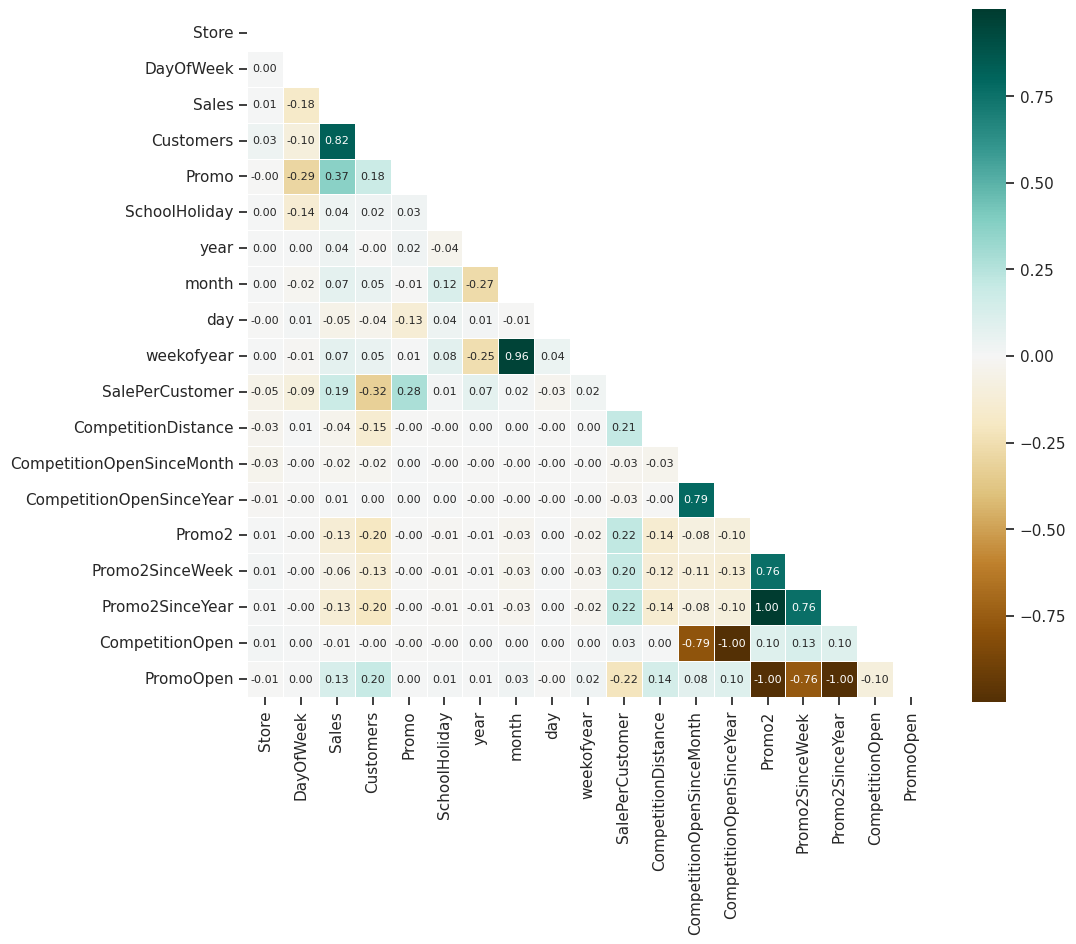

In [140]:
corr_all = train_store[train_store.select_dtypes(include = np.number).columns].drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, annot = True, square = True, linewidths = 0.5, ax = ax, cmap = "BrBG", fmt='.2f',annot_kws = {'fontsize':8})
plt.show()

You can see a strong relationship between sales and the number of customers.

We select the store 562 with the most records for time series analysis.

In [141]:
train['Sales'] = train['Sales'] * 1.0

sales_a = train[train.Store == 2]['Sales']
sales_a

Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
               ...  
2013-01-07    6775.0
2013-01-05    2342.0
2013-01-04    4484.0
2013-01-03    4159.0
2013-01-02    4422.0
Name: Sales, Length: 784, dtype: float64

<Axes: xlabel='Date'>

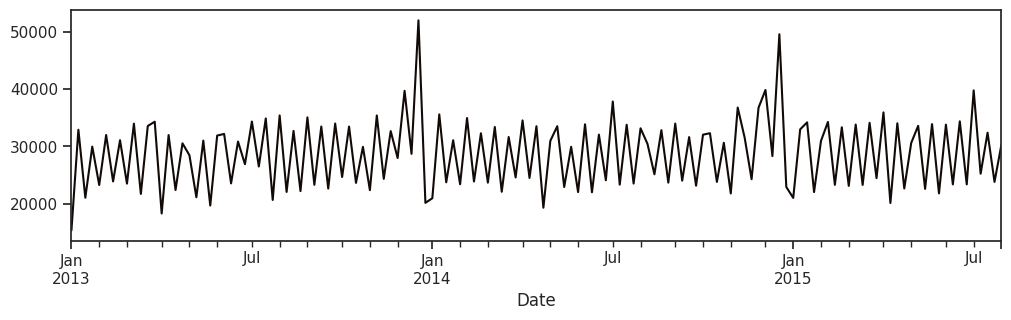

In [142]:
f,ax = plt.subplots(figsize = (12,3))
sales_a.resample('W').sum().plot(color = c , ax = ax)

It always peaks at Christmas time

## Yearly trend

<Axes: xlabel='Date'>

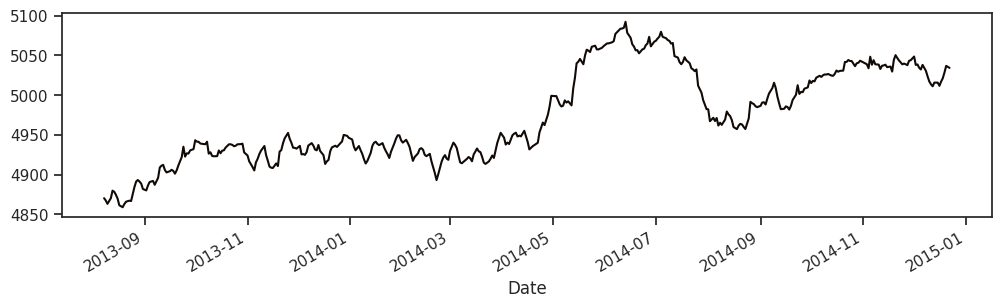

In [143]:
f, ax1 = plt.subplots(figsize = (12,3))
decomposition_a = seasonal_decompose(sales_a, model = 'additive', period =365)
decomposition_a.trend.plot(color = c, ax = ax1)

<Axes: xlabel='Date'>

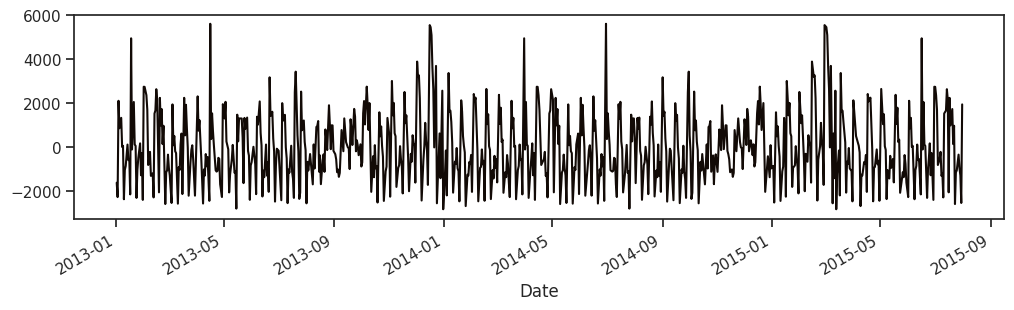

In [144]:
f, ax1 = plt.subplots(figsize = (12,3))
decomposition_a = seasonal_decompose(sales_a, model = 'additive', period =365)
decomposition_a.seasonal.plot(color = c, ax = ax1)

<Axes: xlabel='Date'>

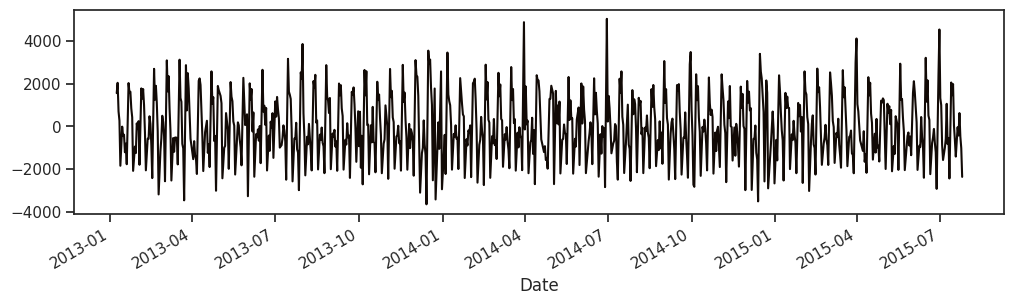

In [145]:
f, ax1 = plt.subplots(figsize = (12,3))
decomposition_a = seasonal_decompose(sales_a, model = 'additive', period =11)
decomposition_a.resid.plot(color = c, ax = ax1)

After eliminating seasonal effects, we can see that the overall development trend of this store is on the rise

## Stationarize the data

In [146]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

In [147]:
def residual_plot(model):

    resid = model.resid
    print(normaltest(resid))
    # returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
    # the residual is not a normal distribution

    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)

    sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

    # Get the fitted parameters used by the function
    (mu, sigma) = stats.norm.fit(resid)

    #Now plot the distribution using
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')


    # ACF and PACF
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(model.resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(model.resid, lags=40, ax=ax2)

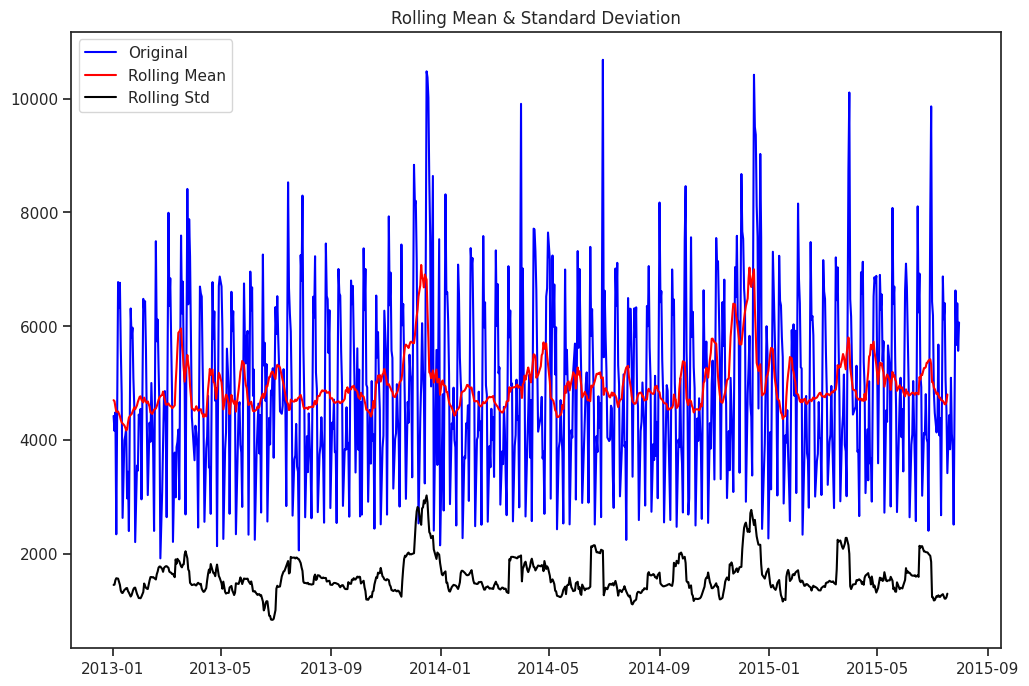

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.292708
p-value                          0.000006
#Lags Used                      17.000000
Number of Observations Used    766.000000
Critical Value (1%)             -3.438916
Critical Value (5%)             -2.865321
Critical Value (10%)            -2.568783
dtype: float64


In [148]:
test_stationarity(sales_a)

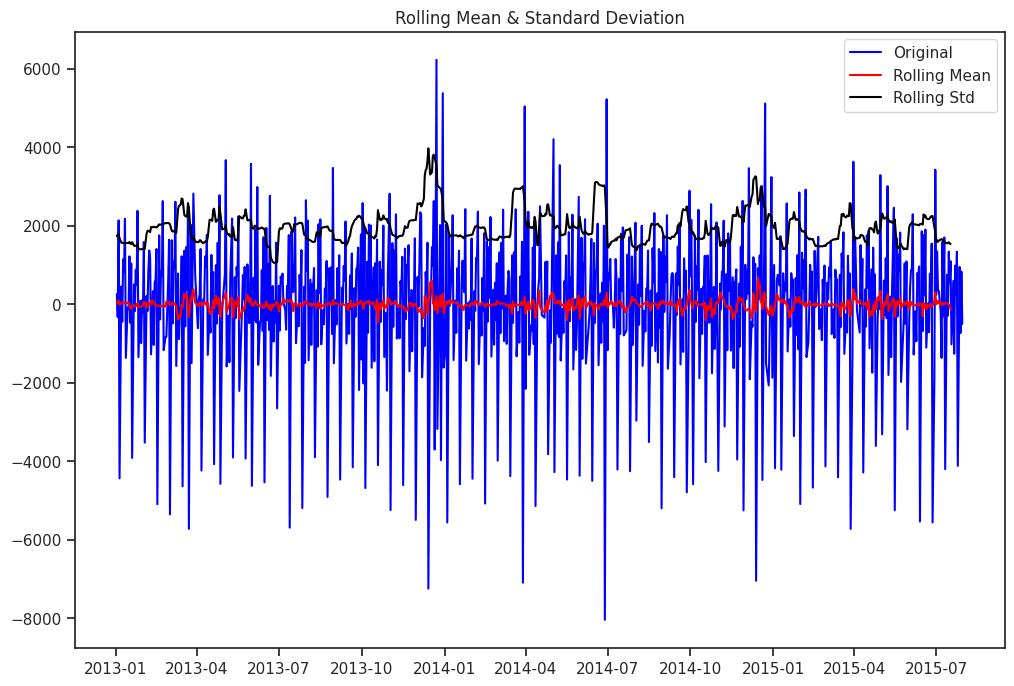

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.219964e+01
p-value                        1.231658e-22
#Lags Used                     1.600000e+01
Number of Observations Used    7.660000e+02
Critical Value (1%)           -3.438916e+00
Critical Value (5%)           -2.865321e+00
Critical Value (10%)          -2.568783e+00
dtype: float64


In [149]:
first_diff_a = sales_a - sales_a.shift(1)
first_diff_a = first_diff_a.dropna(inplace = False)
test_stationarity(first_diff_a, window = 12)

## Plot the ACF and PACF charts and find the optimal parameters

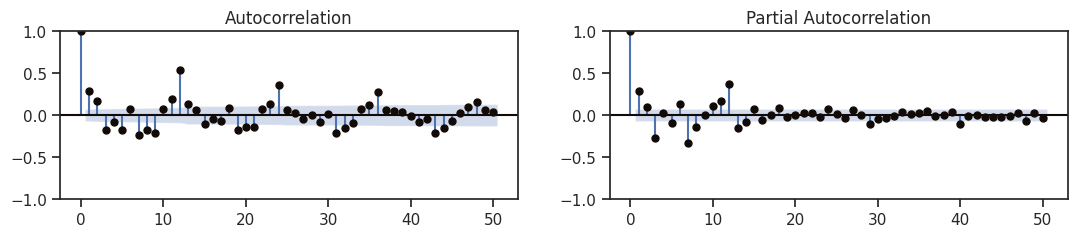

In [150]:
# figure for subplots
plt.figure(figsize = (13, 10))

# acf and pacf for A
plt.subplot(421);
plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422);
plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.show()

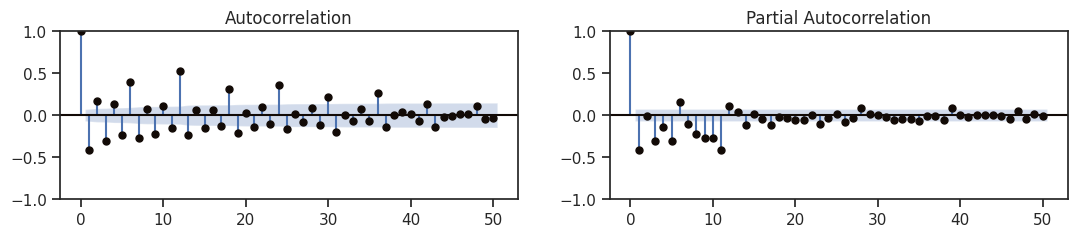

In [151]:
#figure for subplots
plt.figure(figsize = (13, 10))

# acf and pacf for A
plt.subplot(421); plot_acf(first_diff_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(first_diff_a, lags = 50, ax = plt.gca(), color = c)
plt.show()

## Build Model

In [152]:
arima_mod_a = sm.tsa.ARIMA(sales_a, order=(11,1,0)).fit()
print(arima_mod_a.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  784
Model:                ARIMA(11, 1, 0)   Log Likelihood               -6698.797
Date:                Tue, 23 Apr 2024   AIC                          13421.593
Time:                        07:21:43   BIC                          13477.551
Sample:                             0   HQIC                         13443.111
                                - 784                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7256      0.028    -26.155      0.000      -0.780      -0.671
ar.L2         -0.5615      0.030    -18.721      0.000      -0.620      -0.503
ar.L3         -0.6732      0.032    -20.910      0.0

NormaltestResult(statistic=56.09923304545748, pvalue=6.579703517516287e-13)


<ipython-input-147-13879e2e505c>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats


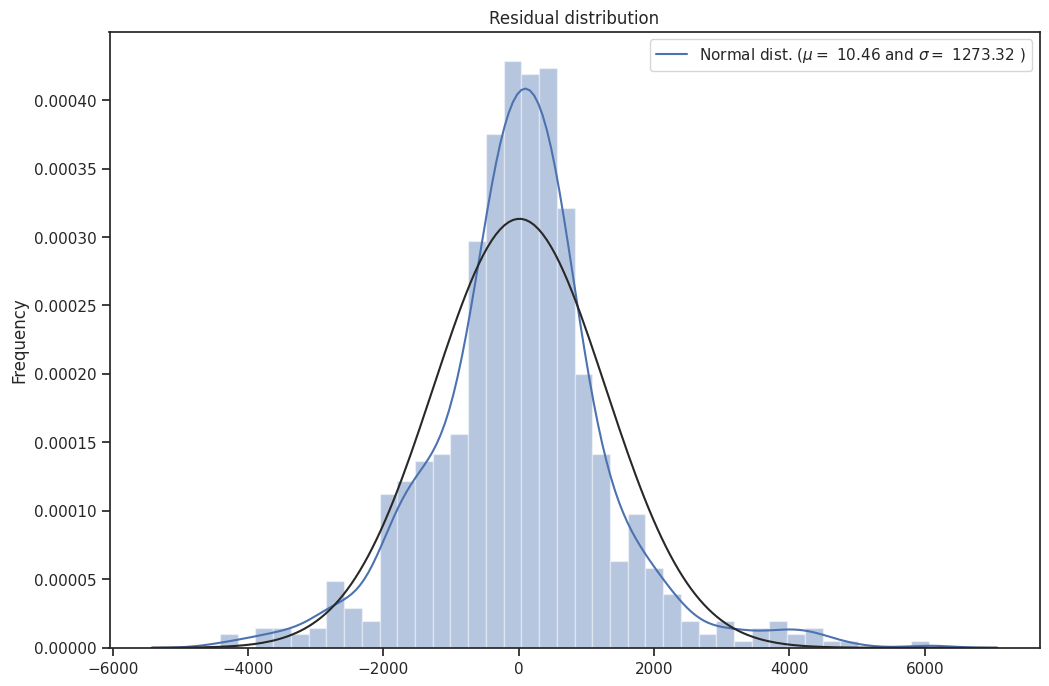

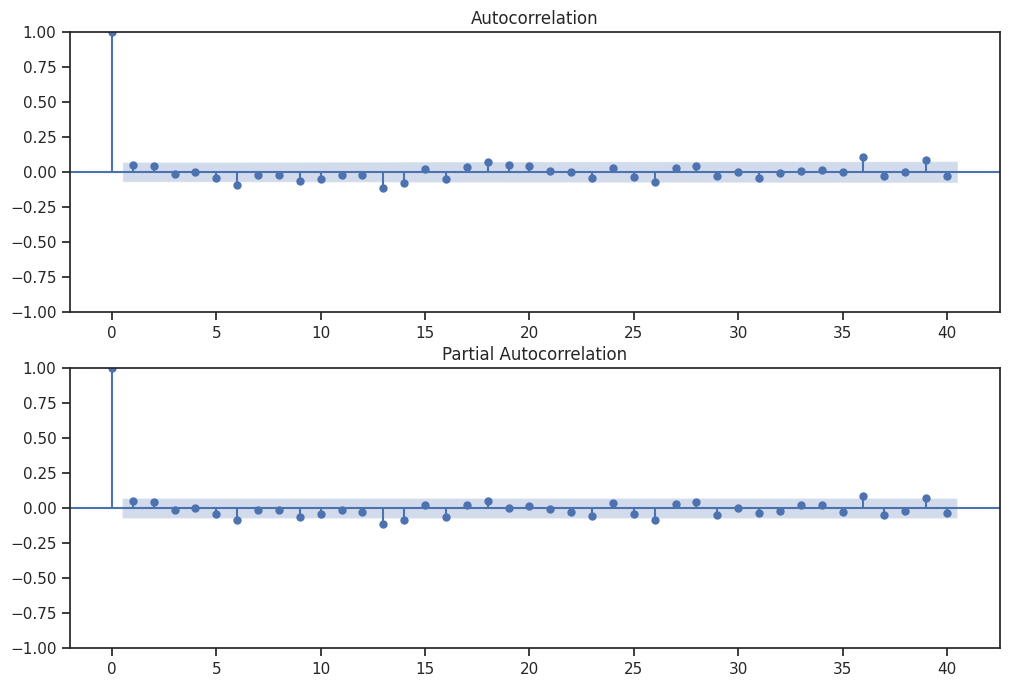

In [153]:
residual_plot(arima_mod_a)

In [154]:
sarima_mod_a = sm.tsa.statespace.SARIMAX(sales_a, trend='n', order=(11,1,0), seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_a.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  784
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6650.912
Date:                             Tue, 23 Apr 2024   AIC                          13329.824
Time:                                     07:22:26   BIC                          13394.891
Sample:                                          0   HQIC                         13354.863
                                             - 784                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6446      0.027    -23.711      0.000      -0.698      -0.591
ar.L2         -0.4139      

NormaltestResult(statistic=53.72265602903733, pvalue=2.159103526266919e-12)


<ipython-input-147-13879e2e505c>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats


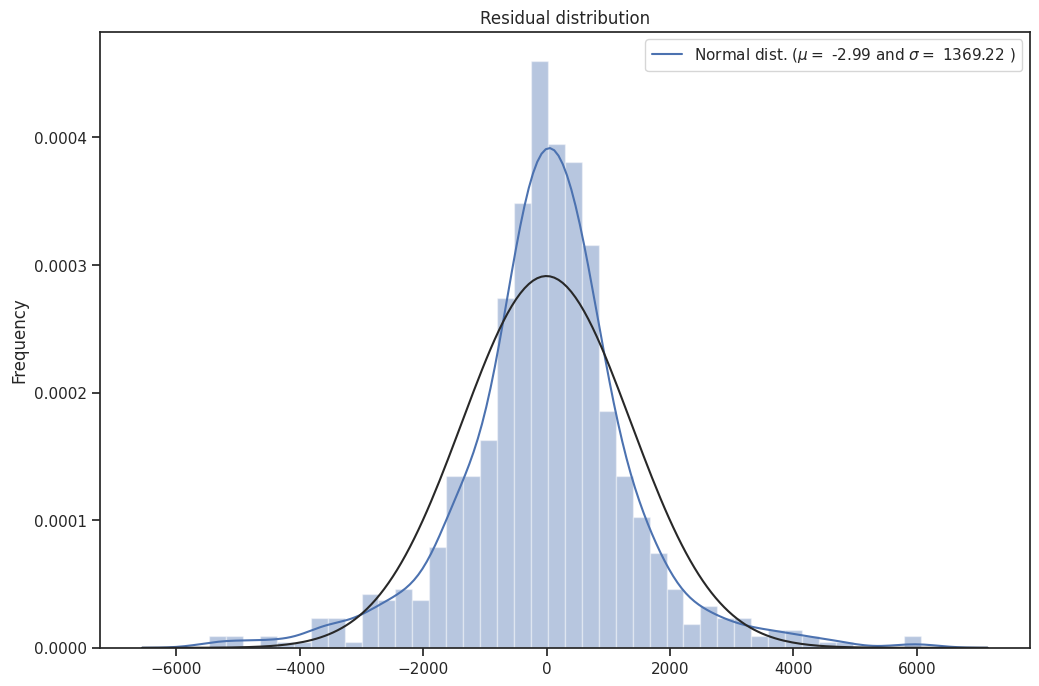

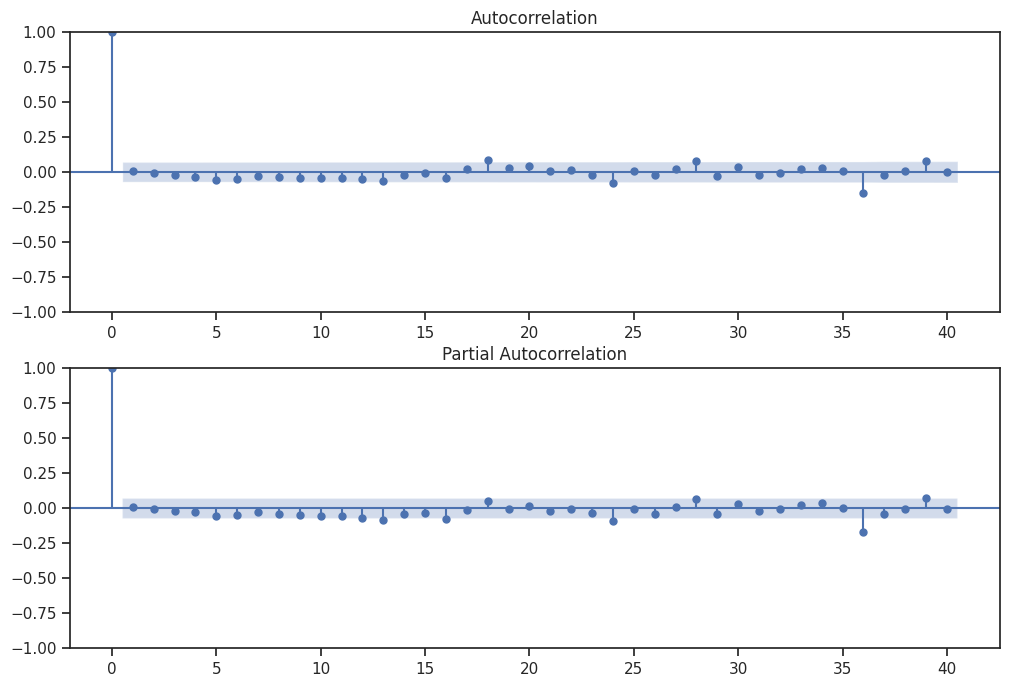

In [155]:
residual_plot(sarima_mod_a)

In [156]:
print(sales_a.shape)
sales_a.head()

(784,)


Date
2015-07-31    6064.0
2015-07-30    5567.0
2015-07-29    6402.0
2015-07-28    5671.0
2015-07-27    6627.0
Name: Sales, dtype: float64

In [157]:
sales_a_reindex = sales_a.reindex(index=sales_a.index[::-1])

In [158]:
sales_a_reindex

Date
2013-01-02    4422.0
2013-01-03    4159.0
2013-01-04    4484.0
2013-01-05    2342.0
2013-01-07    6775.0
               ...  
2015-07-27    6627.0
2015-07-28    5671.0
2015-07-29    6402.0
2015-07-30    5567.0
2015-07-31    6064.0
Name: Sales, Length: 784, dtype: float64

In [159]:
mydata_a = sales_a_reindex
print(mydata_a)

Date
2013-01-02    4422.0
2013-01-03    4159.0
2013-01-04    4484.0
2013-01-05    2342.0
2013-01-07    6775.0
               ...  
2015-07-27    6627.0
2015-07-28    5671.0
2015-07-29    6402.0
2015-07-30    5567.0
2015-07-31    6064.0
Name: Sales, Length: 784, dtype: float64


In [160]:
temp_df = pd.DataFrame(mydata_a)

mydata_a = temp_df

In [161]:
sarima_mod_a_train = sm.tsa.statespace.SARIMAX(mydata_a, trend='n', order=(11,1,0), seasonal_order=(2,1,0,12)).fit()
print(sarima_mod_a_train.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                  784
Model:             SARIMAX(11, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -6650.967
Date:                             Tue, 23 Apr 2024   AIC                          13329.933
Time:                                     07:23:09   BIC                          13395.001
Sample:                                          0   HQIC                         13354.973
                                             - 784                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6429      0.029    -22.226      0.000      -0.700      -0.586
ar.L2         -0.4115      

NormaltestResult(statistic=90.0867181767243, pvalue=2.7410546950027235e-20)


<ipython-input-147-13879e2e505c>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats


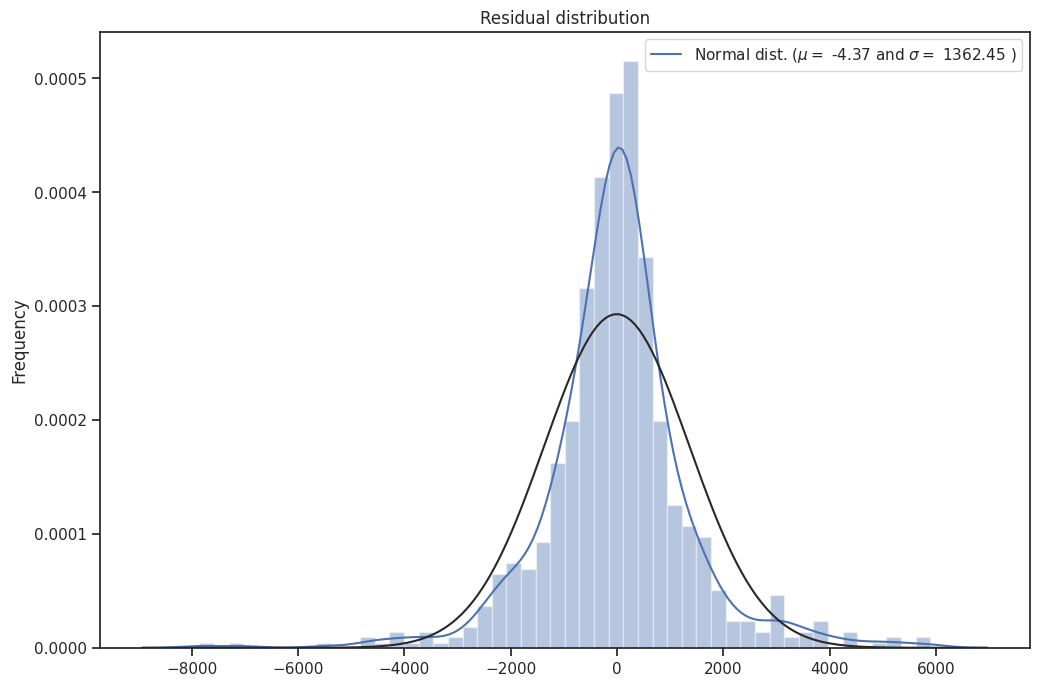

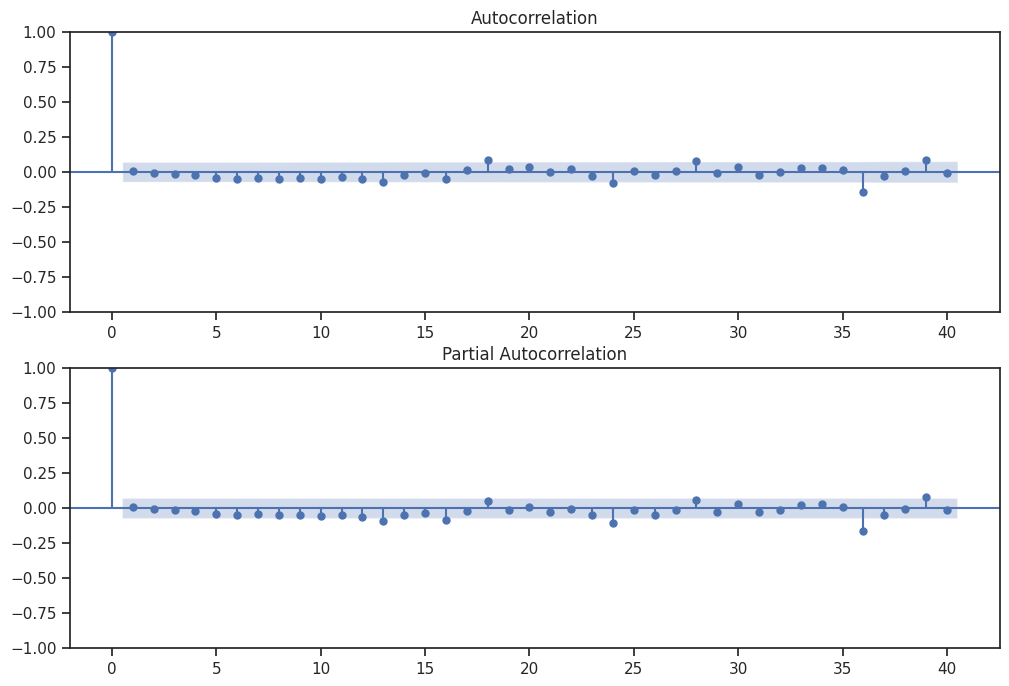

In [162]:
residual_plot(sarima_mod_a_train)

Text(0.5, 0, 'Time')

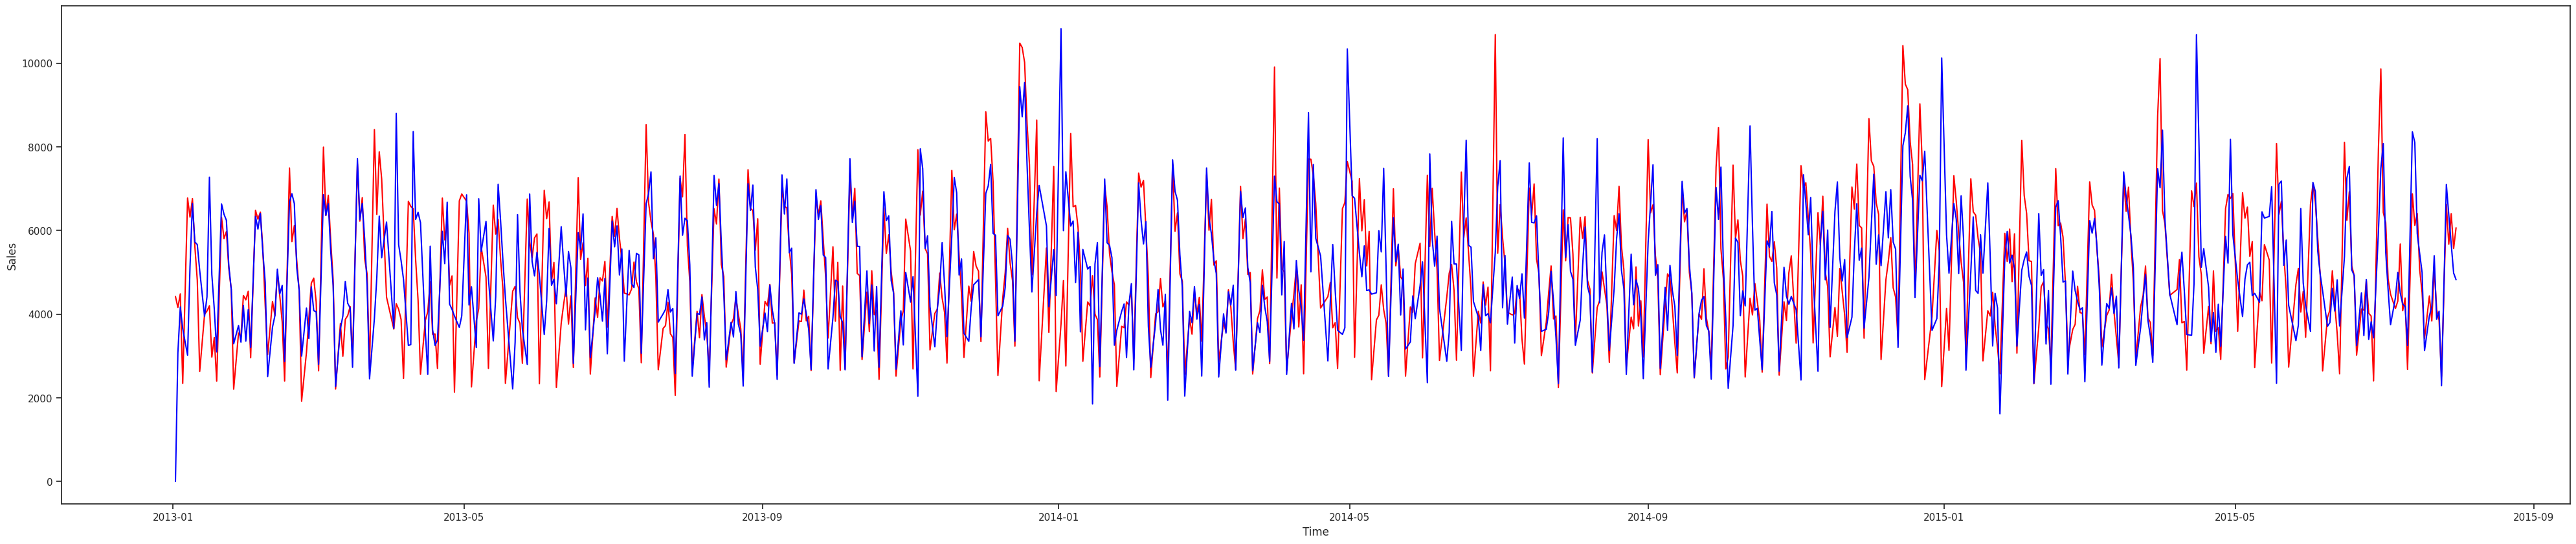

In [163]:
plt.figure(figsize=(50,10))
plt.plot(mydata_a, c='red')
plt.plot(sarima_mod_a_train.fittedvalues, c='blue')
plt.ylabel("Sales")
plt.xlabel("Time")

Date
2015-01-22    4495.672300
2015-01-23    4145.600927
2015-01-24    1617.487840
2015-01-26    5316.761369
2015-01-27    5977.407132
                 ...     
2015-07-27    7101.038607
2015-07-28    6372.793165
2015-07-29    5669.266542
2015-07-30    4981.808190
2015-07-31    4821.876346
Name: predicted_mean, Length: 159, dtype: float64

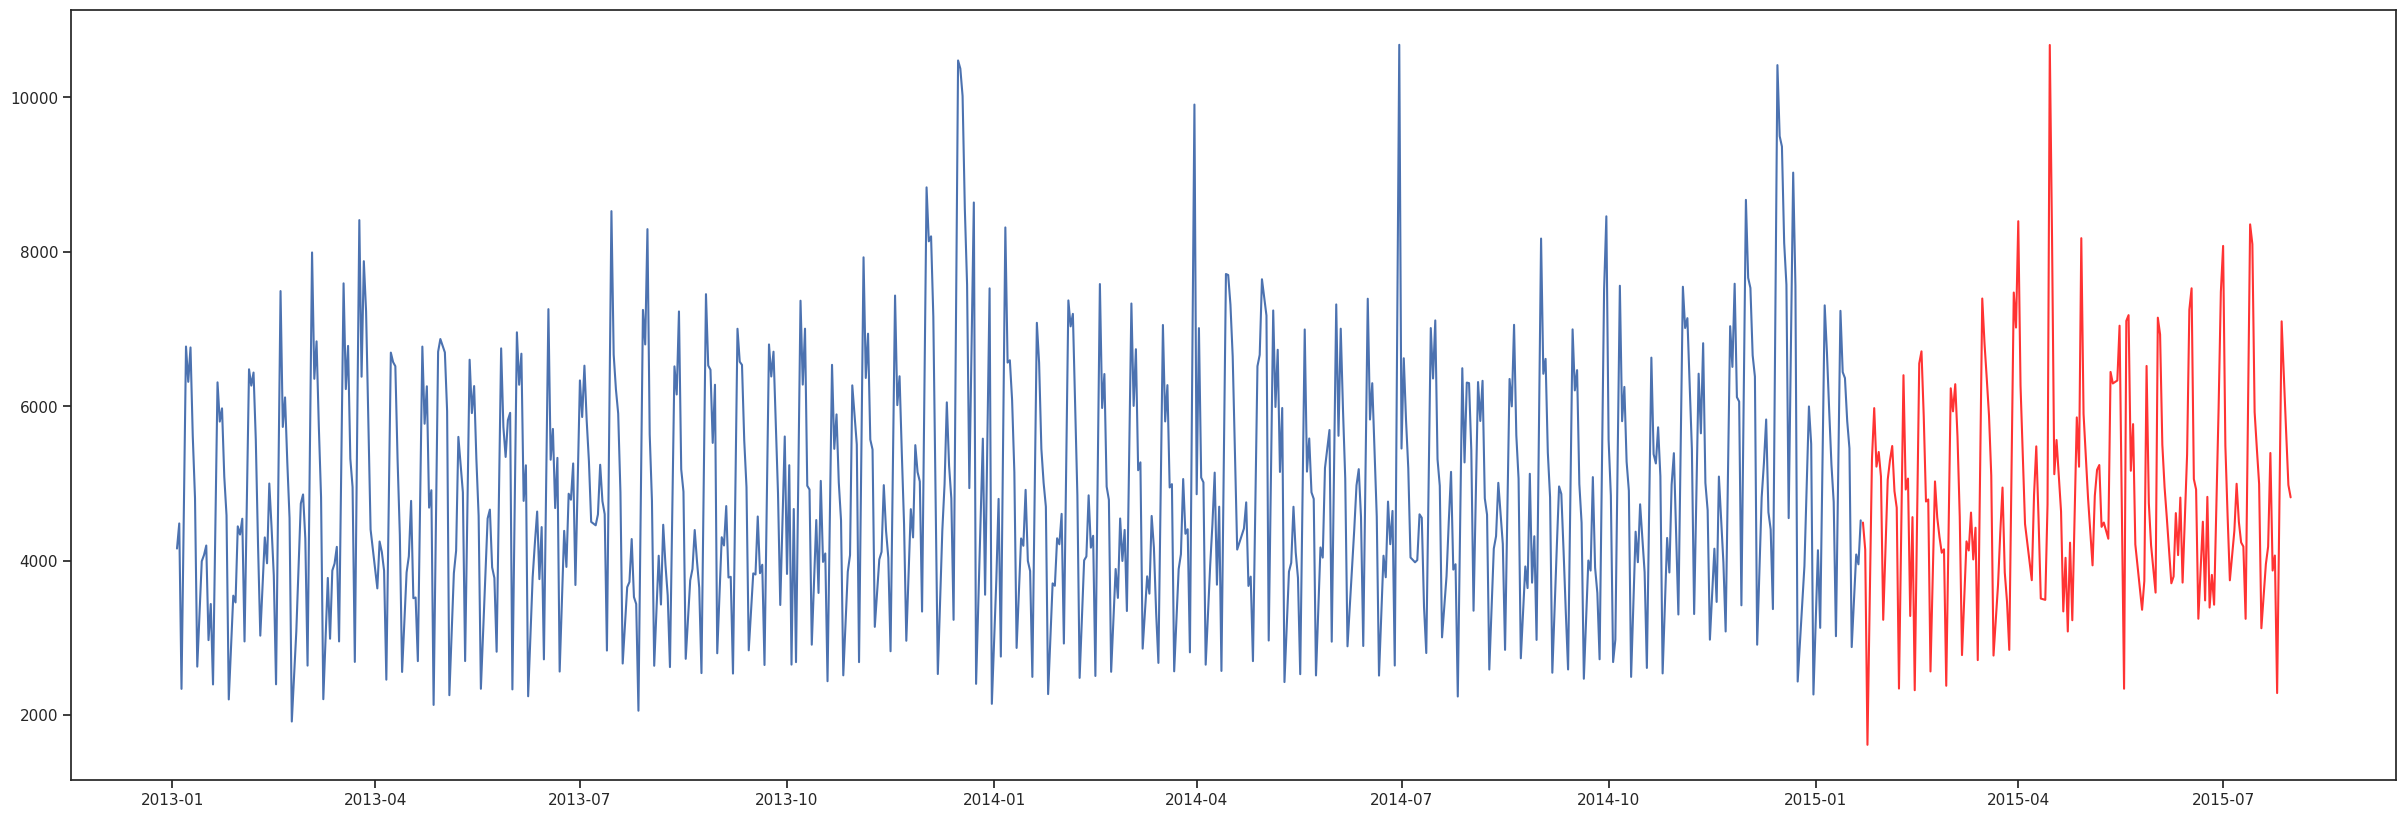

In [164]:
plt.figure(figsize=(30,10))
forecast = sarima_mod_a_train.predict(start = 625, end = 783, dynamic= False)#783
plt.plot(mydata_a.iloc[1:625])
plt.plot(forecast, c = "red",alpha=0.8)
forecast

## LinearRegression

In [165]:
import random

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [166]:
train_store.select_dtypes(include = np.number).columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'year', 'month', 'day', 'weekofyear',
       'SalePerCustomer', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'CompetitionOpen', 'PromoOpen'],
      dtype='object')

In [198]:
test_size = 0.2
random_state = 42  # 设置随机种子以保证结果的可复现性（可选）

# 使用 train_test_split 函数进行划分
X_train, X_test = train_test_split(train_store[train_store['Store']==2], test_size=test_size, random_state=random_state)

In [192]:
# train_store[train_store['Store']==2].to_excel('train_store.xlsx')

In [199]:
# 假设 df 是已加载的 DataFrame，y 列为因变量，X_columns 为自变量列名列表
y_column = 'Sales'  # 替换为实际的因变量列名
X_columns = ['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'year', 'month', 'day', 'weekofyear',
       'SalePerCustomer', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'CompetitionOpen', 'PromoOpen']  # 替换为实际的自变量列名列表

y = X_train[y_column]
X = X_train[X_columns]

In [200]:
X = sm.add_constant(X)

In [201]:
X = X.astype('int64')

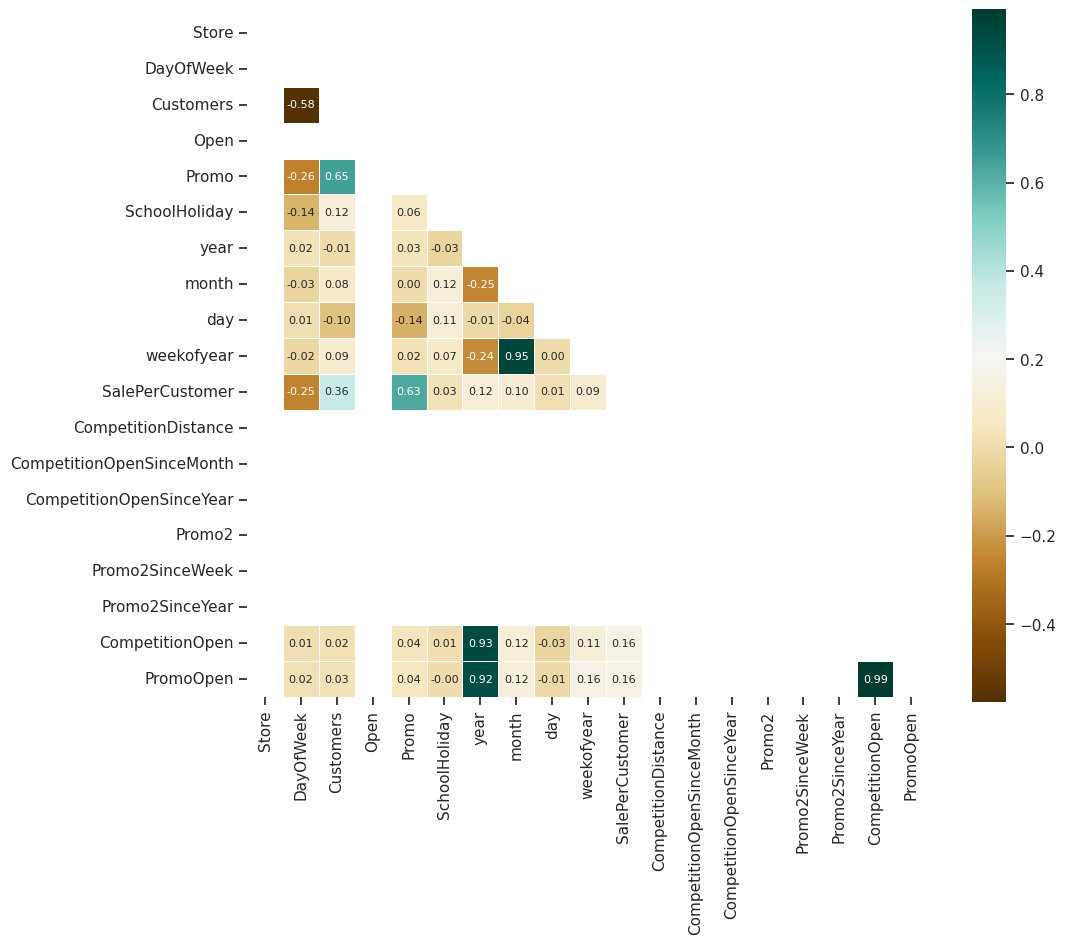

In [203]:
corr_X = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_X, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_X, mask = mask, annot = True, square = True, linewidths = 0.5, ax = ax, cmap = "BrBG", fmt='.2f',annot_kws = {'fontsize':8})
plt.show()

In [204]:
#去除month,Promo2,Promo2SinceYear,open,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,Promo2SinceWeek
X_columns = ['Store', 'DayOfWeek', 'Customers',  'Promo',
       'SchoolHoliday', 'year',  'day', 'weekofyear',
       'SalePerCustomer', 'CompetitionDistance',
       'CompetitionOpen', 'PromoOpen']

X = X_train[X_columns]

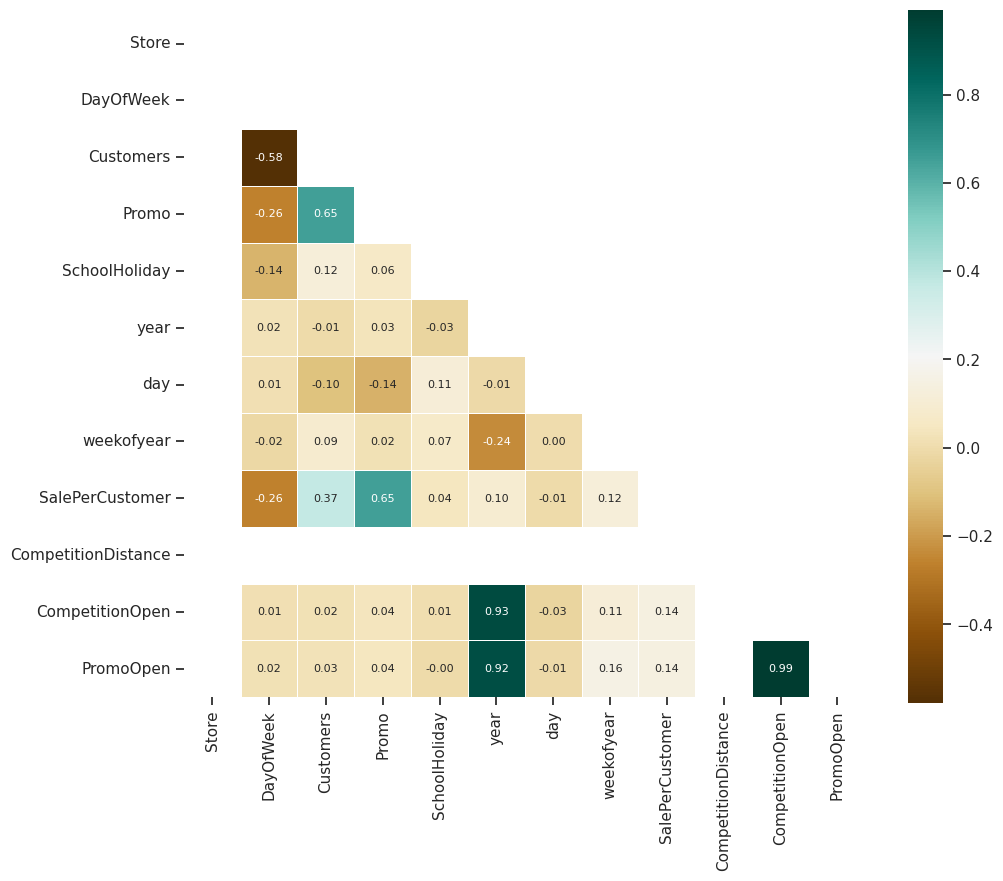

In [205]:
corr_X = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_X, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_X, mask = mask, annot = True, square = True, linewidths = 0.5, ax = ax, cmap = "BrBG", fmt='.2f',annot_kws = {'fontsize':8})
plt.show()

In [206]:
X = X.astype('int64')

In [207]:
X['Intercept']=1

In [208]:
# 拟合线性回归模型
model = sm.OLS(y,X)
result = model.fit()

In [209]:
result.pvalues

Store                   3.278907e-01
DayOfWeek               8.041014e-04
Customers              7.753372e-319
Promo                   5.861666e-01
SchoolHoliday           6.691064e-01
year                    3.302665e-01
day                     5.122390e-01
weekofyear              2.473429e-01
SalePerCustomer        1.072126e-203
CompetitionDistance     3.278907e-01
CompetitionOpen         1.201258e-01
PromoOpen               5.221506e-01
Intercept               3.278907e-01
dtype: float64

In [210]:
result.rsquared

0.9772789019811798

In [211]:
np.sqrt(np.mean(result.resid**2))#rmse

244.47261439964763

In [212]:
result.params

Store                    -5.210412
DayOfWeek               -25.189829
Customers                 8.123695
Promo                    18.177935
SchoolHoliday            10.847420
year                    419.010314
day                      -0.773608
weekofyear               10.289906
SalePerCustomer         626.918189
CompetitionDistance   -1484.967406
CompetitionOpen         -15.264569
PromoOpen               -22.659848
Intercept                -2.605206
dtype: float64

## Test

In [213]:
X_test['Intercept']=1

In [214]:
X_columns.append('Intercept')

In [215]:
y_pred = result.predict(X_test[X_columns])

In [216]:
print("RMSE:",np.sqrt(np.mean((X_test[y_column]-y_pred)**2)))

RMSE: 473.1343187225776


In [217]:
n_points = len(y_pred)
random_numbers = [random.randint(1,len(y_pred)) for _ in range(200)]

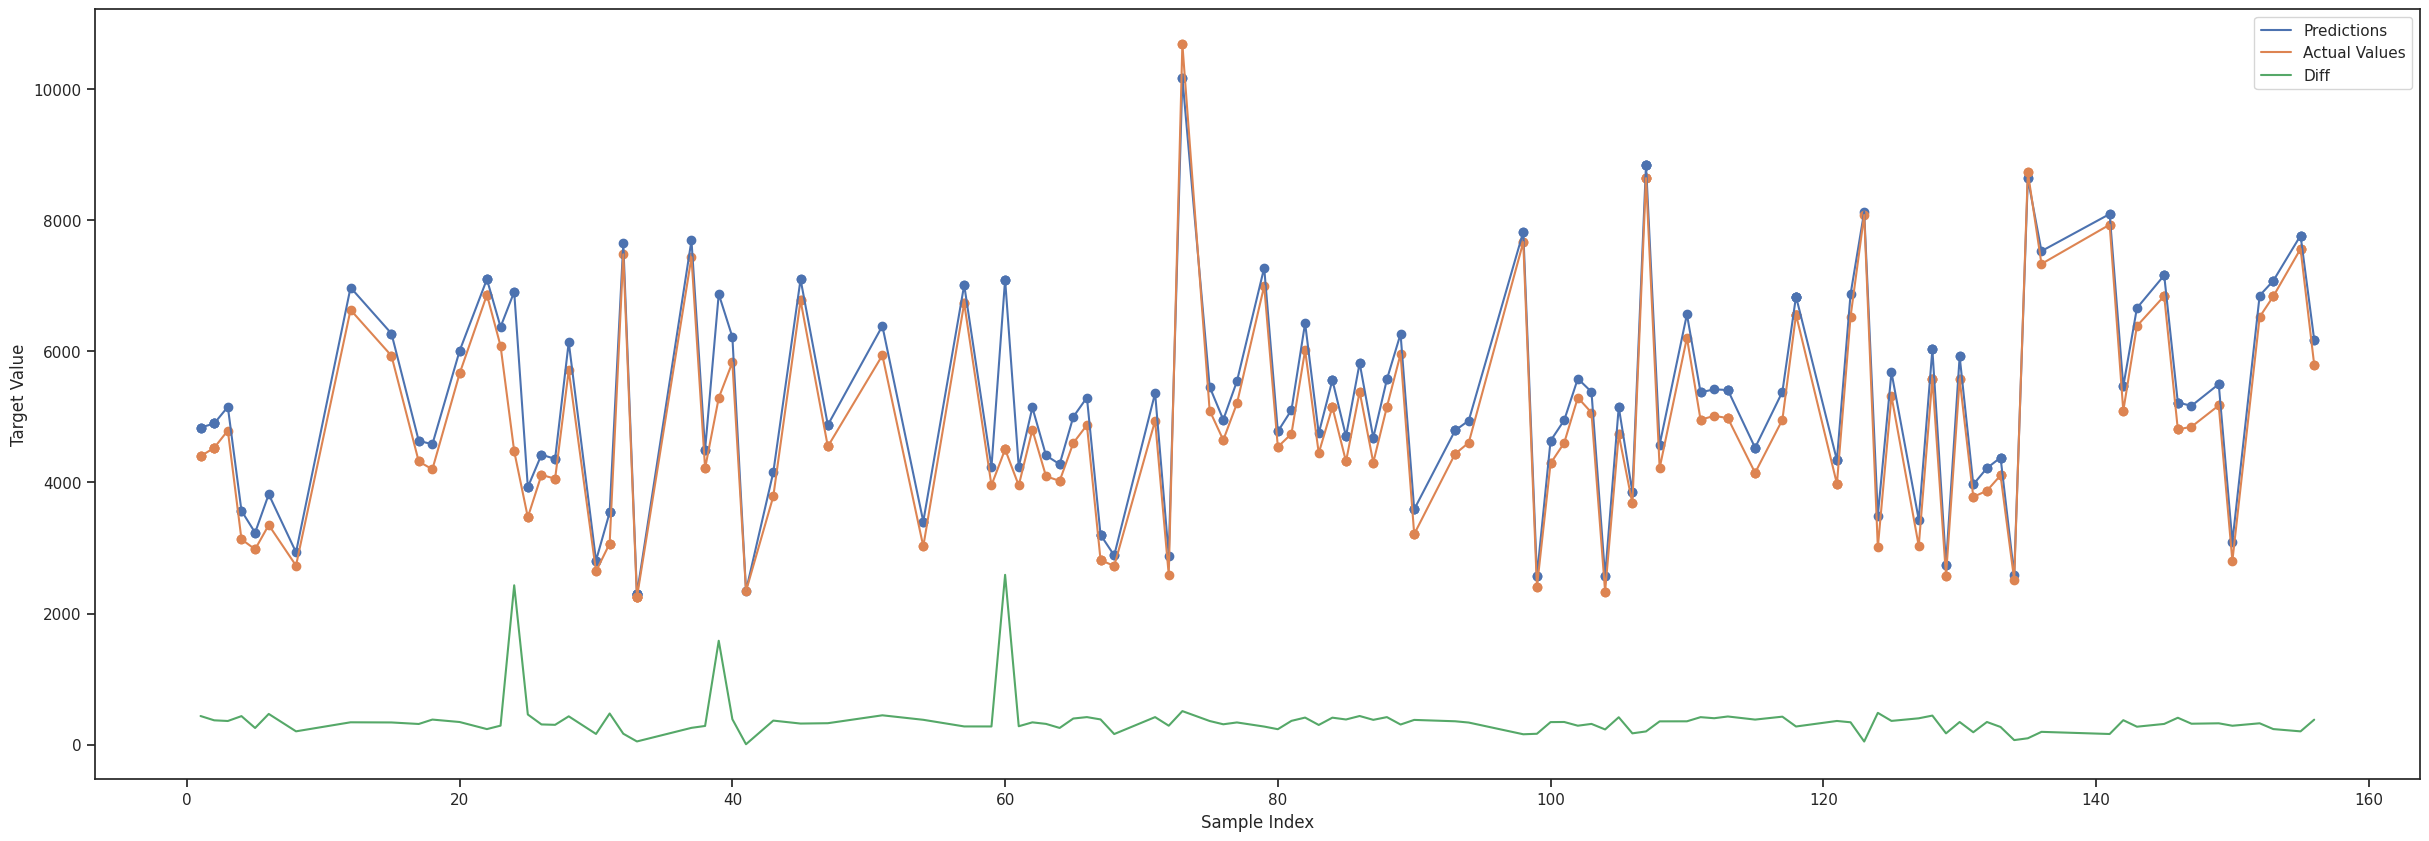

In [218]:
# 绘制折线图
plt.figure(figsize=(30,10))

plt.plot(sorted(random_numbers),y_pred.iloc[sorted(random_numbers)], label='Predictions')
plt.plot(sorted(random_numbers), X_test[y_column].iloc[sorted(random_numbers)], label='Actual Values')
plt.plot(sorted(random_numbers), abs(X_test[y_column].iloc[sorted(random_numbers)]-y_pred.iloc[sorted(random_numbers)]), label='Diff')

plt.scatter(sorted(random_numbers),y_pred.iloc[sorted(random_numbers)])
plt.scatter(sorted(random_numbers), X_test[y_column].iloc[sorted(random_numbers)])
# 设置坐标轴标签
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Target Value')

# 显示图形
plt.show()